In [1]:
# Dependencies
from src.dataset import GaussianNoise, SaltPepperNoise, OcclusionNoise, RandomNoise, Clip, ToTensor, Compose
from src.dataset import MNIST, train_test_split
from src.network import AutoEncoder, train_test_epoch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import random
import torch
import tqdm
import json
import os

# Set random seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Get best device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Show selected device
print('Selected device:', device)

# Setup matplotlib
%matplotlib inline

Selected device: cpu


In [2]:
# Define path to root folder
ROOT_PATH = '.'
# Define path to data folder
DATA_PATH = ROOT_PATH + '/data'
# Define path to MNIST dataset
MNIST_PATH = DATA_PATH +'/MNIST.mat'
# Define path to modles folder
MODEL_PATH = DATA_PATH + '/models'

## Dataset

In [3]:
# Load dataset and set random transformations

# Load MNIST dataset from file
mnist = MNIST.from_mat(MNIST_PATH)

# Define random noise choice
random_noise = RandomNoise([
    # No noise
    Clip(),
    # Gaussian noise
    Compose([GaussianNoise(mu=0, sigma=0.4), Clip()]),
    # salt and pepper noise
    Compose([SaltPepperNoise(perc=0.4), Clip()]),
    # Occlusion noise
    Compose([OcclusionNoise(perc=0.4), Clip()])
])
# Define cast to tensor
to_tensor = ToTensor()
# Add to tensor transformation
mnist.transform = Compose([random_noise, to_tensor])

# Show mnist dataset length
print('Loaded MNIST dataset contains {:d} images'.format(len(mnist)))

Loaded MNIST dataset contains 60000 images


In [4]:
# Split MNIST dataset into train and test one
train_data, test_data = train_test_split(mnist, train_perc=0.8)

# Show new datasets length
print('Training dataset has length {:d}'.format(len(train_data)))
print('Test dataset has length {:d}'.format(len(test_data)))

Training dataset has length 48000
Test dataset has length 12000


In [5]:
# Define sample of tuples (expected output images, all possible noise transformations)

# Initialize expected images (one per digit)
in_images, out_images = [], []
# Retrieve available noise transformations
noise_transforms = random_noise.transforms
# Loop through each available digit
for i in range(10):
    # Go through each image in test dataset
    for out_label, _, out_image in test_data:
        
        # Cast output label to integer
        out_label = out_label.item()
        # Cast expected output image no numpy array
        out_image = out_image.squeeze(0).numpy()
        
        # Case current label does not match index
        if i != out_label:
            # Skip and go to next iteration
            continue
        
        # Initialize list of noised images
        noise_images = []
        # Loop through each available transformation
        for transform in noise_transforms:
            # Apply transformation, retrieve noise input image
            _, in_image, _ = transform(out_label, out_image.copy(), out_image.copy())
            # Store noised image
            noise_images.append(in_image)
        
        # Concatenate images together
        noise_images = np.stack(noise_images, axis=0)
        # Store noised images
        in_images.append(noise_images)
        # Store expected image
        out_images.append(out_image)
        
        # Exit inner loop, go to next digit
        break
        
# Concatenate output images
out_images = torch.tensor(np.stack(out_images, axis=0))
# Concatenate input images
in_images = torch.tensor(np.stack(in_images, axis=0))
# Wrap both output and input images in a single test sample
test_sample = (in_images, out_images)

# Check images shape
print('Expected output images have shape %s,' % str(out_images.shape), end=' ')
print('while input images have shape %s' % str(in_images.shape))

Expected output images have shape torch.Size([10, 28, 28]), while input images have shape torch.Size([10, 4, 28, 28])


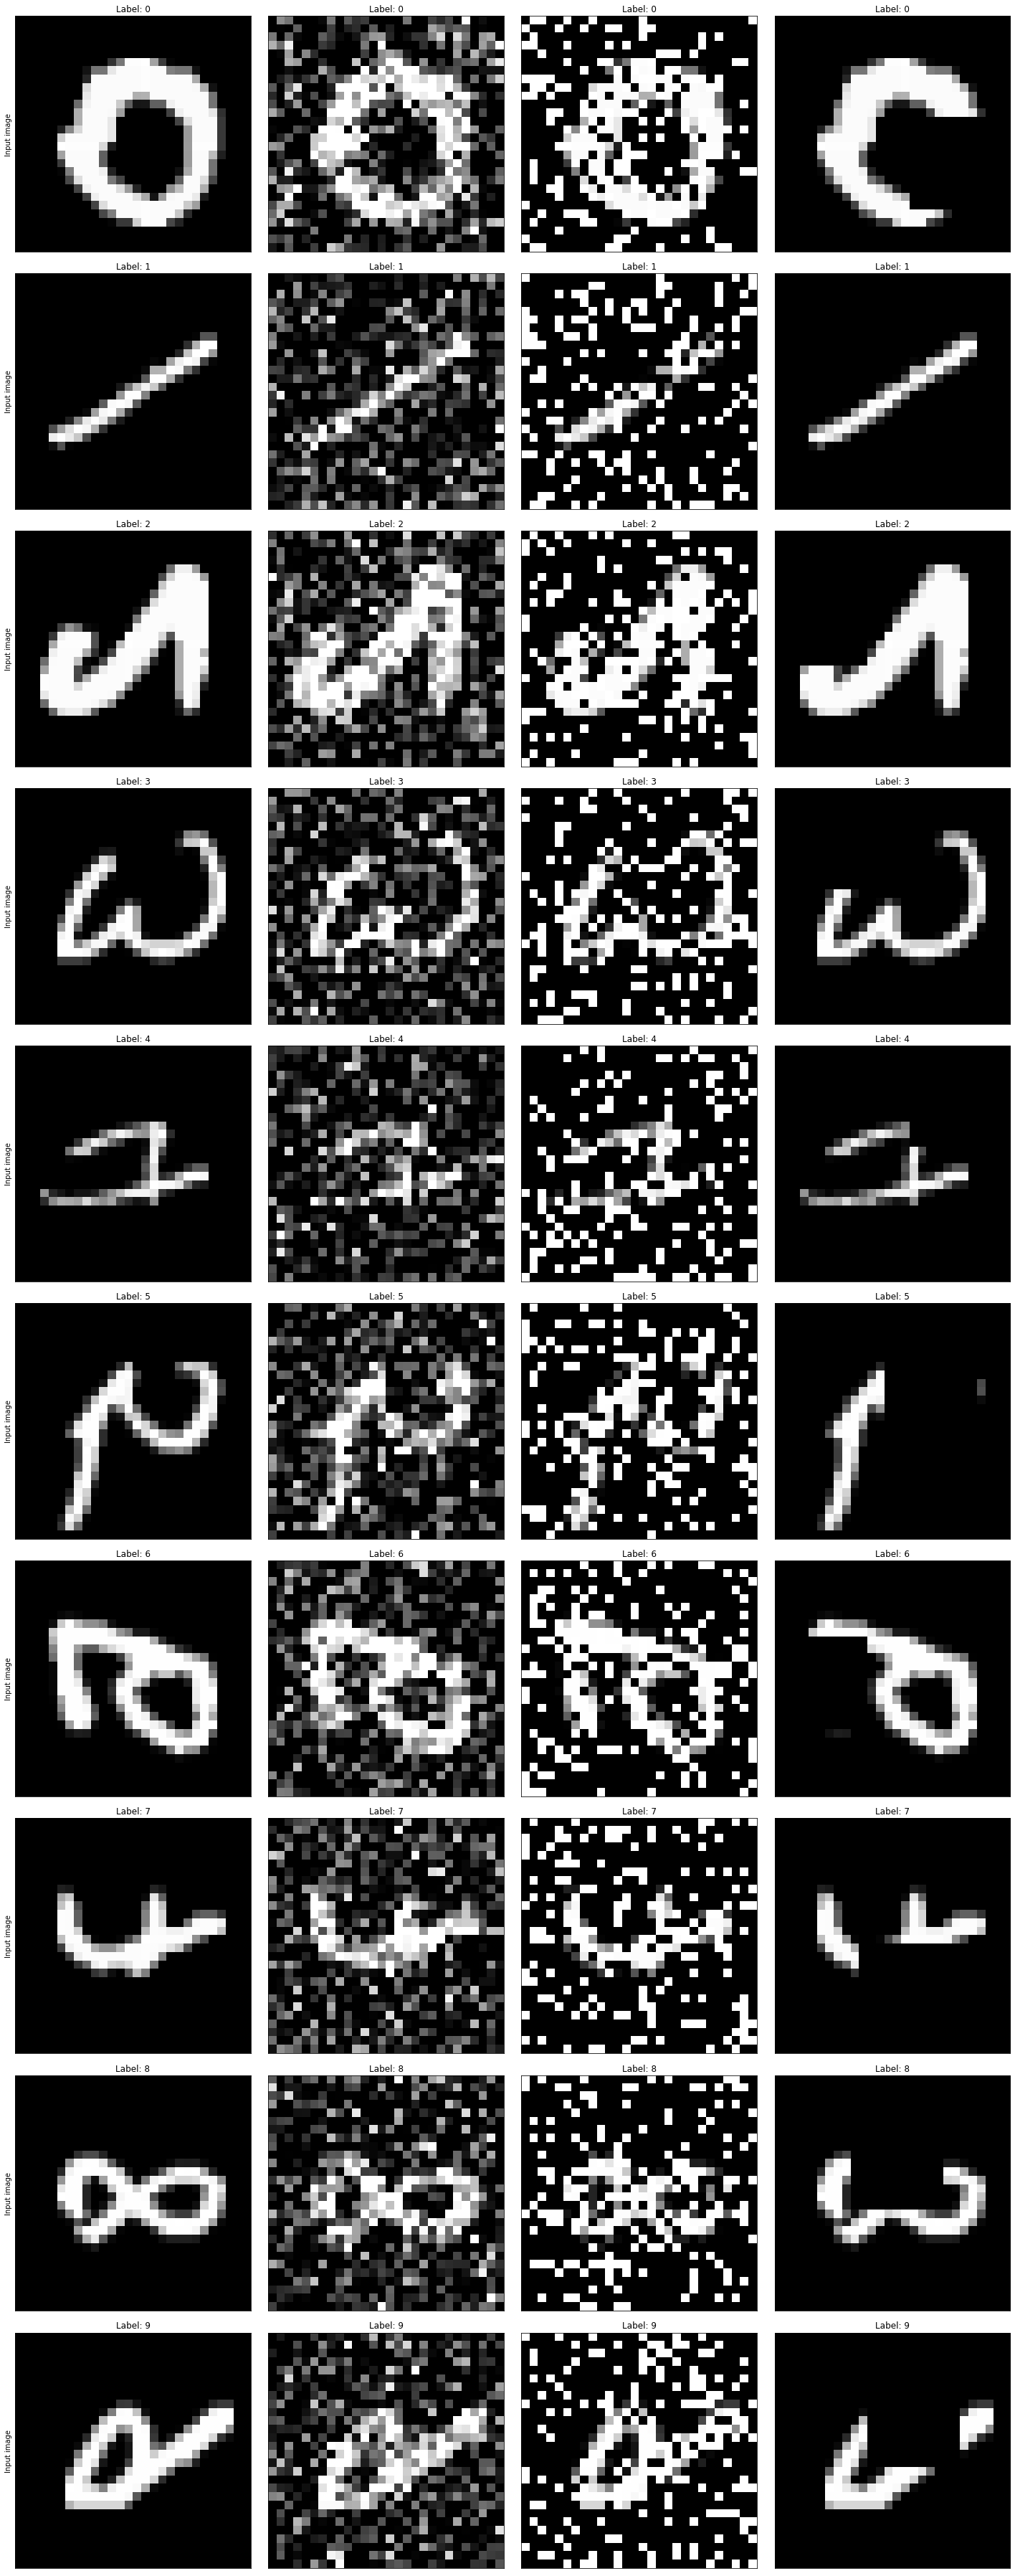

In [6]:
# Show digits test sample

# Define function for plotting test sample
def plot_sample(in_images, out_images, net_images=None, digit_size=5):

    # Define number of input images and transformations
    n, m = in_images.shape[:2]
    # Define plot rows and columns
    r, c = n, m
    
    # Duplicate rows in case reconstructed images have been set
    r = r if (net_images is None) else (r * 2)
        
    # Initialize plot
    fig, axs = plt.subplots(r, c, figsize=(c * digit_size, r * digit_size))
    # Loop through each row
    for i in range(n):
        # Make new row index
        k = i if (net_images is None) else (i * 2)
        
        # Set input images label
        axs[k + 0, 0].set_ylabel('Input image')
        # Case reconstructed images are given
        if (net_images is not None):
            # Set reconstructed images label
            axs[k + 1, 0].set_ylabel('Reconstructed image')
        
        # Loop through each column
        for j in range(m):
            # Plot input digit
            MNIST.plot_digit(i, in_images[i, j, :, :], ax=axs[k + 0, j])
            # Case reconstructed images must be plotted
            if (net_images is not None):
                # Plot reconstructed digit
                MNIST.plot_digit(i, net_images[i, j, :, :], ax=axs[k + 1, j])
    
    # Tighten layout
    plt.tight_layout()
    
# Show original, ot reconstructed test sample
plot_sample(*test_sample)
# Save plot
plt.savefig('data/images/sample.png', dpi=100)
# Show plot
plt.show()

### Model training

In [7]:
# Set model parameters

# Define name of the model: if set, load it, otherwise a new one will be created
# NOTE: setting model name enables training
MODEL_NAME = '2020_09_04_11_44_30_ae'
# Set number of latent dimensions
LATENT_DIM = 2
# Define batch size to use during training and evaluation
BATCH_SIZE = 1000
# Define number of training epochs
NUM_EPOCHS = 1000
# Define number of epochs between two checkpoints
SAVE_AFTER = 10
# Set optimizer linear rate
OPTIM_LR = 1e-3
# Set optimizer weight decay
OPTIM_WD = 1e-5

In [8]:
# Define train and test dataloader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
# Train the network

# Define new network and move it to selected device
net = AutoEncoder(latent_dim=LATENT_DIM).to(device)
# Define optimizer
optim = torch.optim.Adam(net.parameters(), lr=OPTIM_LR, weight_decay=OPTIM_WD)
# Define loss function
loss_fn = torch.nn.MSELoss()

# Initialize empty model path
model_path = ''
# Case model name is set: load model
if MODEL_NAME:
    # Define path to already trained model
    model_path = MODEL_PATH + '/' + MODEL_NAME

# Case model name is not set: train a new one
if not MODEL_NAME:

    # Get actual datatime
    now = datetime.datetime.now()
    # Define new model directory path (set YEAR_MONTH_DAY_HOUR_MINUTE_SECOND)
    model_path = MODEL_PATH + '/%s_ae' % now.strftime('%Y_%m_%d_%H_%M_%S')

    # Case model path does not exist
    if not os.path.isdir(model_path):
        # Create a new one
        os.mkdir(model_path)
    
    # Define epochs iterator
    epochs_iter = tqdm.tqdm(range(NUM_EPOCHS))
    # Define epochs table
    epochs_table = []  # {'train_loss': [], 'train_time': [], 'test_loss': [], 'test_time': []}
    # Loop through each epoch
    for e in epochs_iter:
        # Train and test current epoch
        train_loss, train_time, test_loss, test_time = train_test_epoch(
            # Define network to be trained and evaluated
            net=net,
            # Define loss function
            loss_fn=loss_fn,
            # Define optimizer
            optim=optim,
            # Define training dataset
            train_data=train_loader,
            # Define evaluation dataset
            test_data=test_loader
        )
        # Store current epoch losses and times into table
        epochs_table.append({
            'train_loss': train_loss,
            'train_time': train_time,
            'test_loss': test_loss,
            'test_time': test_time
        })
        
        # Print out current epoch train loss
        print('Train loss %.06f' % train_loss)
        print('Test loss %.06f' % test_loss)
        
        # Make checkpoint (if required interval or last epoch has been reached)
        if ((e + 1) % SAVE_AFTER == 0) or (e + 1 == NUM_EPOCHS):
            
            # Retrieve input images
            in_images, out_images = test_sample
            # Define reconstructed images list
            net_images = []
            # Set network in evaluation mode
            net.eval()
            # Disable gradient computation
            with torch.no_grad():
                # Loop through each input image batch
                for j in range(in_images.shape[1]):
                    # Define input images batch
                    net_input = in_images[:, j, :, :]
                    # Add channel dimension and move to selected device
                    net_input = net_input.unsqueeze(1).to(net.device)
                    # Compute network output and remove channel dimension
                    net_output = net(net_input).cpu()
                    # Store output
                    net_images.append(net_output)
                    
            # Make single reconstructed images tensor
            net_images = torch.cat(net_images, dim=1)
            # Make plot
            plot_sample(*test_sample, net_images)
            # Save plot
            plt.savefig(model_path + ('/epoch_%04d' % (e + 1)))
            # Close plot
            plt.close()
            
            # Write model weights to file (0verwrite)
            torch.save(net.state_dict(), model_path + '/params.pth')
            
            # Store epochs (override)
            with open(model_path + '/epochs.json', 'w') as file:
                # Write epochs to file
                json.dump(epochs_table, file)

# Load model
net.load_state_dict(torch.load(model_path + '/params.pth', map_location=net.device))
# Set network in evaluation mode
net.eval()
# Move network to selected device
net.to(device)

# Load epochs table into a pandas dataframe
epochs_table = pd.read_json(model_path + '/epochs.json')
# Show header
epochs_table.head()

,train_loss,train_time,test_loss,test_time
0,0.226140,4.132432,0.132051,0.448174
1,0.103013,3.953740,0.085654,0.398244
2,0.074619,3.917093,0.070022,0.449609
3,0.067845,3.974590,0.066662,0.398105
4,0.065427,3.917162,0.064877,0.456290


#### Digits

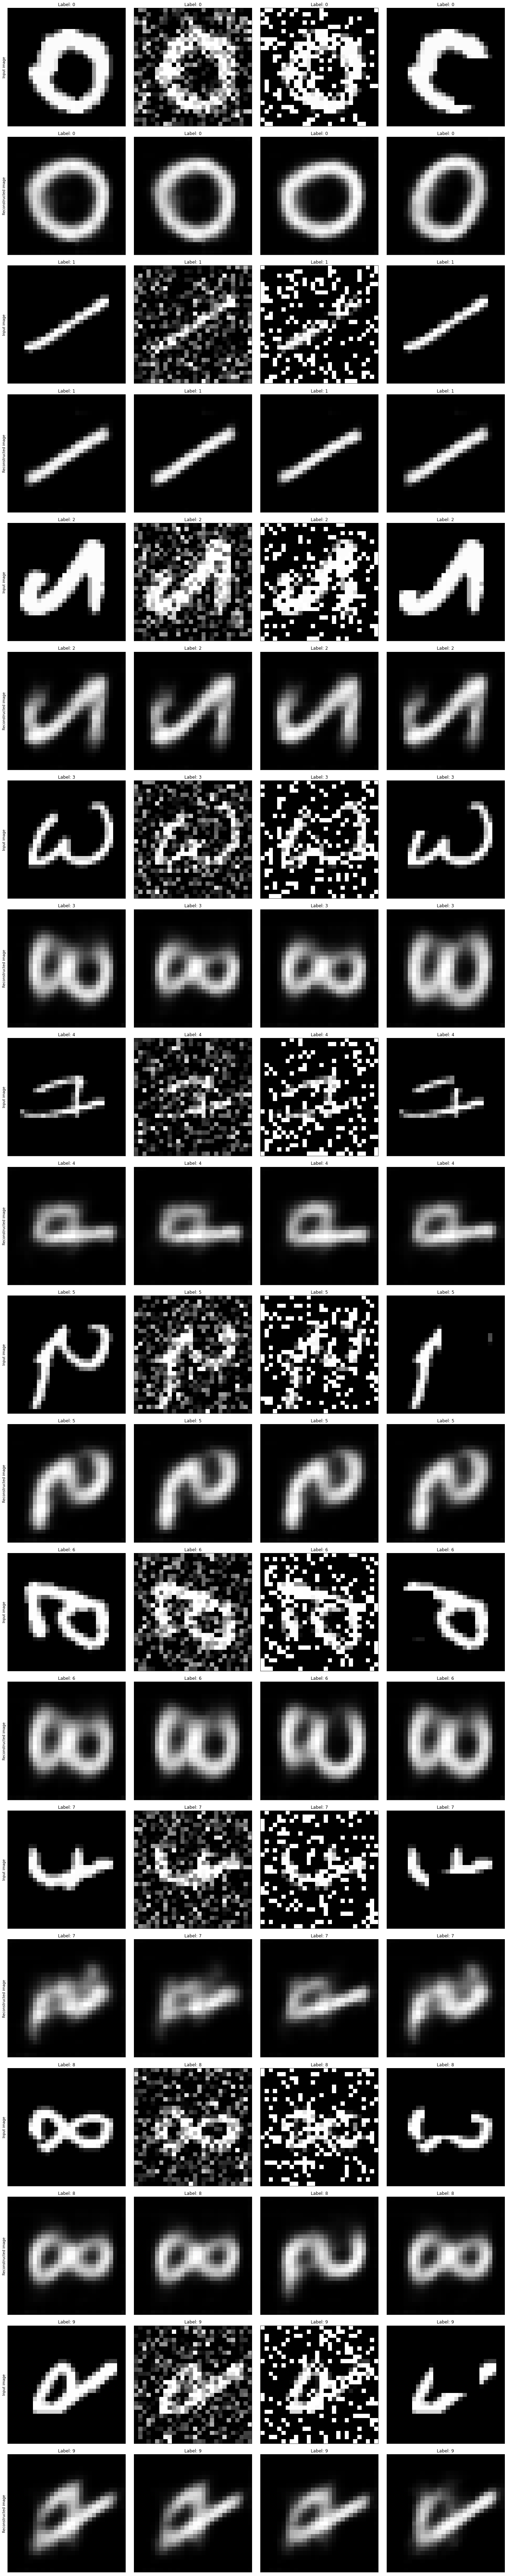

In [10]:
# Show digits reconstruction on test sample

 # Retrieve input images
in_images, out_images = test_sample
# Define reconstructed images list
net_images = []
# Disable gradient computation
with torch.no_grad():
    # Loop through each input image batch
    for j in range(in_images.shape[1]):
        # Define input images batch
        net_input = in_images[:, j, :, :]
        # Add channel dimension and move to selected device
        net_input = net_input.unsqueeze(1).to(net.device)
        # Compute network output and remove channel dimension
        net_output = net(net_input).cpu()
        # Store output
        net_images.append(net_output)
        
# Make single reconstructed images tensor
net_images = torch.cat(net_images, dim=1)
# Make test sample plot
plot_sample(*test_sample, net_images)
# Save plot
plt.savefig('data/images/prediction_ae.png', dpi=100)
# show plot
plt.show()

#### Loss

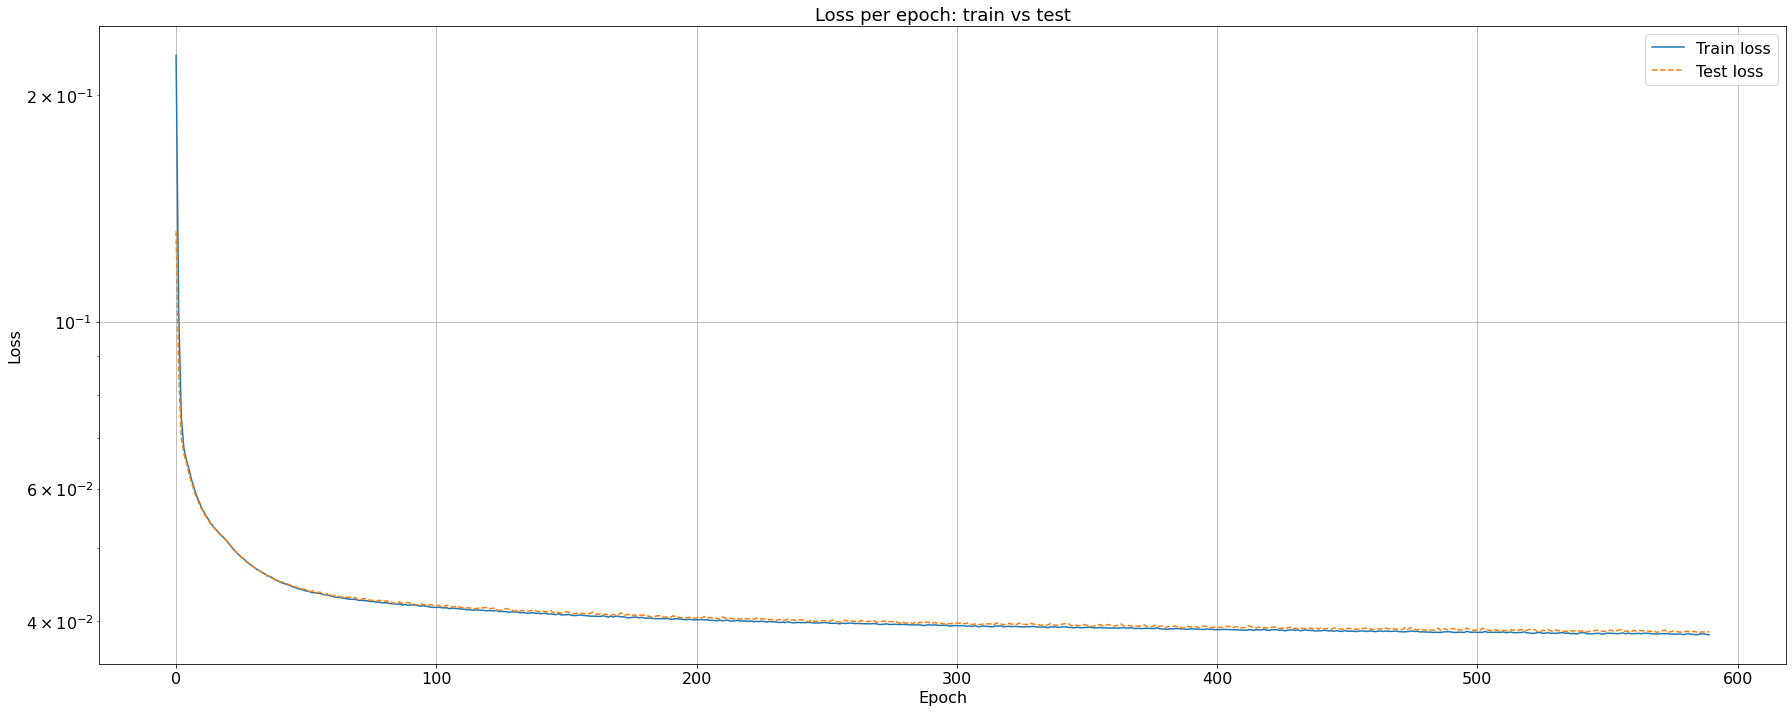

In [17]:
# Plot loss per epoch

# Define train and test losses
train_loss = epochs_table.train_loss
test_loss = epochs_table.test_loss

# Initialize plot: show either train and test losses
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
# Make train loss plot
ax.semilogy(train_loss, label='Train loss')
# Make test loss plot
ax.semilogy(test_loss, label='Test loss', ls='--')
# Define title and labels
ax.set_title('Loss per epoch: train vs test', fontsize=18)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
# Set ticks font
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
# Add grid
ax.grid()
# Add legend
ax.legend(fontsize=16)
# Tighten layout
plt.tight_layout()
# Save plot
plt.savefig('data/images/loss_ae.png', dpi=100)
# Make plot
plt.show()

### Latent space

In [12]:
# Retrieve test sample encodings

# Disable gradient computation
with torch.no_grad():
    
    # Initialize encoded images and labels lists
    enc_labels, enc_images = [], []
    
    # Loop through every batch in test dataset
    for out_labels, in_images, _ in test_loader:
        # Move input images to selected device
        in_images = in_images.to(device)
        # Encode images
        enc_images.append(net.encode(in_images).cpu())
        # Store labels
        enc_labels.append(out_labels.cpu())
        
# Concatenate all encoded images
enc_images = torch.cat(enc_images, dim=0).numpy()
# Concatenate all encoded labels
enc_labels = torch.cat(enc_labels, dim=0).numpy()

# Show either images and labels shape
print('Encoded images have shape (latent space dimension) %s' % str(enc_images.shape), end=' ')
print('while labels have shape %s' % str(enc_labels.shape))

Encoded images have shape (latent space dimension) (12000, 2) while labels have shape (12000, 1)


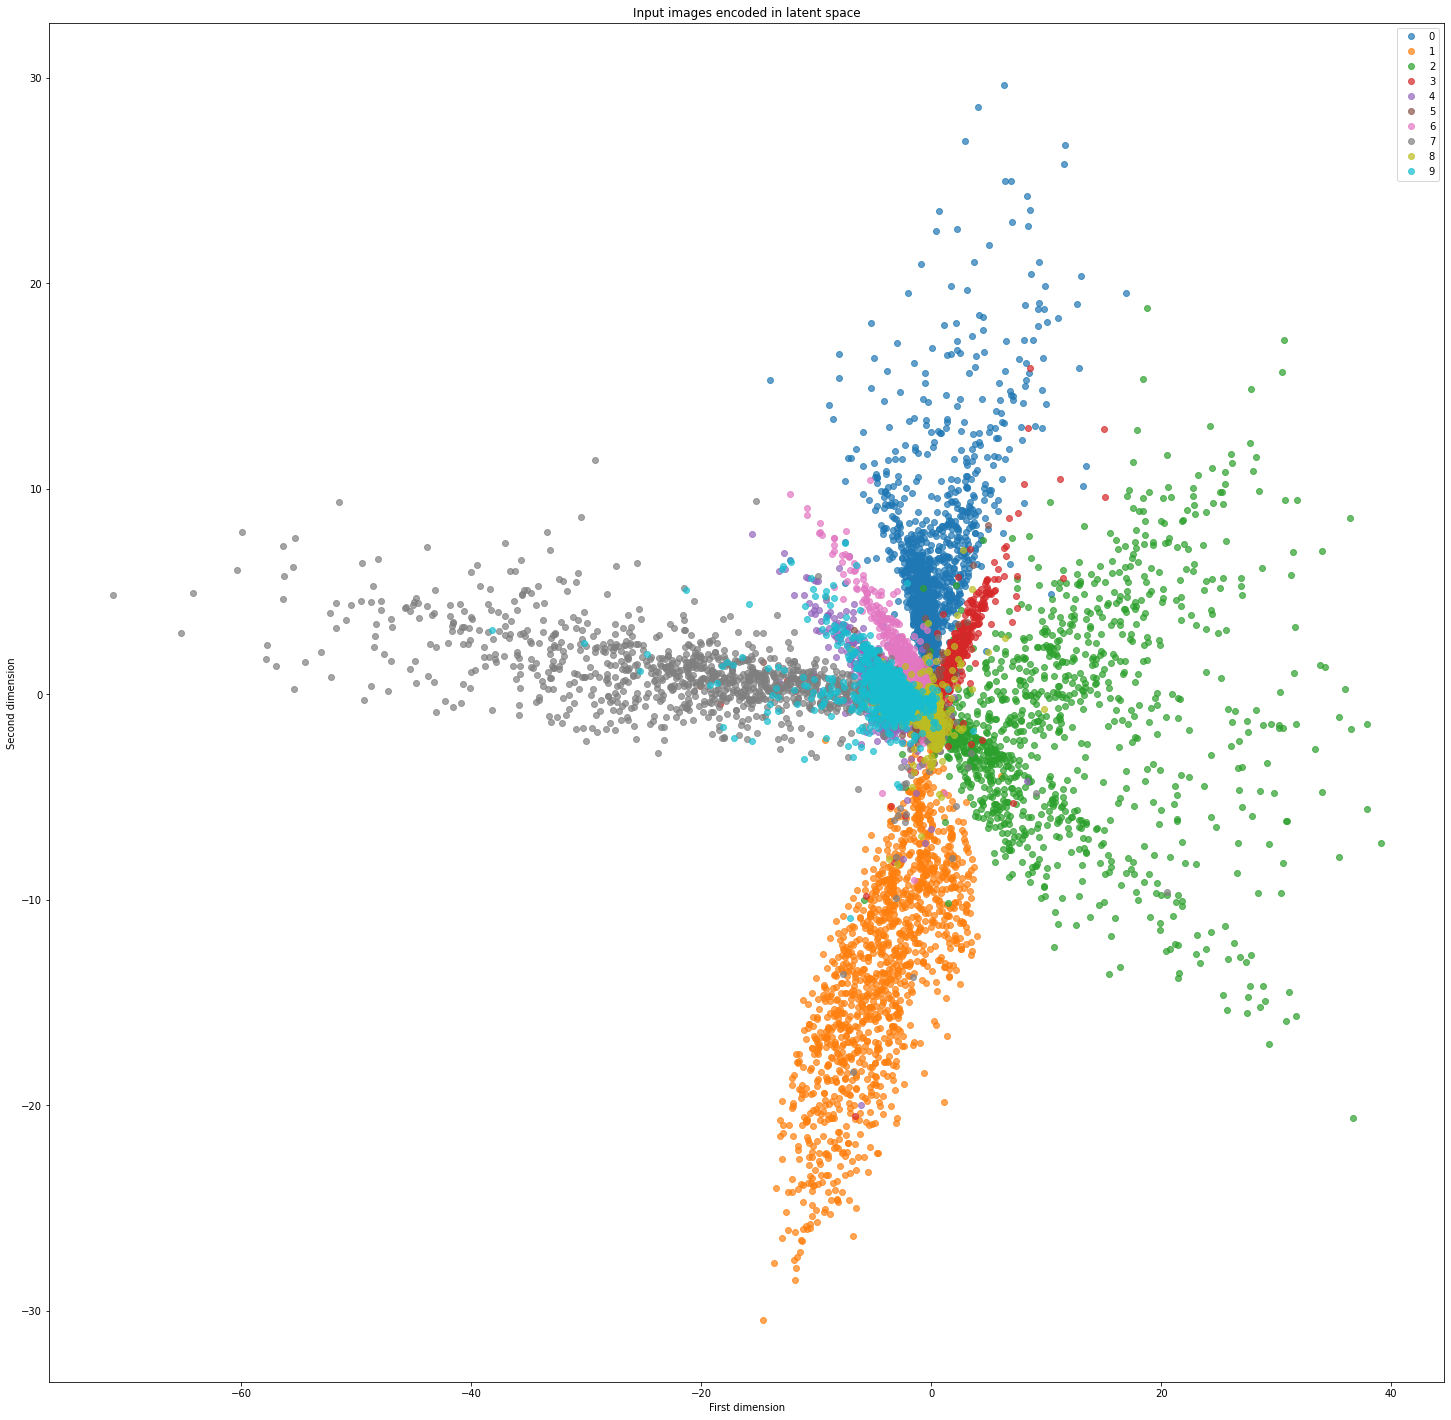

In [13]:
# Plot latent dimension

# Define digits
digits = sorted(set(enc_labels[:, 0]))

# Initialize plot: show 2 dimensional latent space
fig, ax = plt.subplots(figsize=(25, 25))
# Go through each digit
for i in digits:
    # Define x, y points
    xy = enc_images[enc_labels[:, 0] == i]
    # Make plot
    plt.plot(xy[:, 0], xy[:, 1], alpha=.7, linestyle='', marker='o')
# Set title and labels
ax.set_title('Input images encoded in latent space')
ax.set_ylabel('Second dimension')
ax.set_xlabel('First dimension')
# Show label
ax.legend(digits)
# Save plot
plt.savefig('data/images/latent_space_ae.png', dpi=100)
# Show plot
plt.show()